# Dual Numbers & Automatic Differentiation - A Walkthrough

In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_palette("Set1")
sns.set_context('paper')

In [2]:
class DataLoader(object):
    # Small class object for generating synthetic data
    def __init__(self, n, d, batch_size, binary=False):
        self.total_dim = d + 1
        self.X, self.y = self.generate_regression_data(n, d, binary)
        # Set batch_id for different indices
        self.num_batches = np.ceil(n/batch_size).astype(int)
        self.batch_ids = np.array([np.repeat(i, batch_size) for i in range(self.num_batches)]).flatten()[:n]

    def generate_regression_data(self, n, d, binary=False):
        # Generate the regression/classification data from Gaussians
        self.b_true = self.generate_coefficients(d)
        X = np.random.normal(0, 1, n*d).reshape((n, d))
        noise = np.random.normal(0, 1, n).reshape((n, 1))
        inter = np.ones(n).reshape((n, 1))
        X = np.hstack((inter, X))
        y = np.matmul(X, self.b_true) + noise
        # Make data binary if task is classification/logistic regression
        if binary:
            y[y > 0] = 1
            y[y <= 0] = 0
        return X, y

    def generate_coefficients(self, d, intercept=True):
        # Generate random integer-valued coefficients for Xb + e
        b_random = np.random.randint(-5, 5, d + intercept)
        return b_random.reshape((d + intercept, 1))

    def shuffle_arrays(self):
        # Shuffle the dataset for diversity when looping over batches
        assert len(self.X) == len(self.y)
        p = np.random.permutation(len(self.X))
        self.X, self.y = self.X[p], self.y[p]

    def get_batch_idx(self, batch_id):
        # Subselect the current batch to be processed!
        idx = np.where(self.batch_ids == batch_id)[0]
        return self.X[idx, :], self.y[idx].flatten()

In [3]:
class DualTensor(object):
    # Class object for dual representation of a tensor/matrix/vector
    def __init__(self, real, dual):
        self.real = real
        self.dual = dual

    def zero_grad(self):
        # Reset the gradient for the next batch evaluation
        dual_part = np.zeros((len(self.real), len(self.real)))
        np.fill_diagonal(dual_part, 1)
        self.dual = dual_part
        return

def dot_product(b_dual, x, both_require_grad=False):
    # Function to perform dot product between a dual and a no grad_req vector
    real_part = np.dot(x.real, b_dual.real)
    dual_part = np.dot(x.real, b_dual.dual)
    if both_require_grad:
         dual_part += np.dot(b_dual.real, x.dual)
    return DualTensor(real_part, dual_part)

def add_duals(dual_a, dual_b):
    # Operator non-"overload": Add a two dual numbers
    real_part = dual_a.real + dual_b.real
    dual_part = dual_a.dual + dual_b.dual
    return DualTensor(real_part, dual_part)

def log(dual_tensor):
    # Operator non-"overload": Log (real) & its derivative (dual)
    real_part = np.log(dual_tensor.real)
    temp_1 = 1/dual_tensor.real
    # Fill matrix with diagonal entries of log derivative
    temp_2 = np.zeros((temp_1.shape[0], temp_1.shape[0]))
    np.fill_diagonal(temp_2, temp_1)
    dual_part = np.dot(temp_2, dual_tensor.dual)
    return DualTensor(real_part, dual_part)

def sigmoid(dual_tensor):
    # Operator non-"overload": Sigmoid (real) & its derivative (dual)
    real_part = 1/(1+np.exp(-dual_tensor.real))
    temp_1 = np.multiply(real_part, 1-real_part)
    # Fill matrix with diagonal entries of sigmoid derivative
    temp_2 = np.zeros((temp_1.shape[0], temp_1.shape[0]))
    np.fill_diagonal(temp_2, temp_1)
    dual_part = np.dot(temp_2, dual_tensor.dual)
    return DualTensor(real_part, dual_part)

# Logistic Regression in Dual Mode!

In [4]:
def forward(X, b_dual):
    # Apply element-wise sigmoid activation
    y_pred_1 = sigmoid(dot_product(b_dual, X))
    y_pred_2 = DualTensor(1-y_pred_1.real, -y_pred_1.dual)
    # Make numerically stable!
    y_pred_1.real = np.clip(y_pred_1.real, 1e-15, 1-1e-15)
    y_pred_2.real = np.clip(y_pred_2.real, 1e-15, 1-1e-15)
    return y_pred_1, y_pred_2

def binary_cross_entropy_dual(y_true, y_pred_1, y_pred_2):
    # Compute actual binary cross-entropy term
    log_y_pred_1, log_y_pred_2 = log(y_pred_1), log(y_pred_2)
    bce_l1, bce_l2 = dot_product(log_y_pred_1, -y_true), dot_product(log_y_pred_2, -(1 - y_true))
    bce = add_duals(bce_l1, bce_l2)
    # Calculate the batch classification accuracy
    acc = (y_true == (y_pred_1.real > 0.5)).sum()/y_true.shape[0]
    return bce, acc

In [16]:
def train_logistic_regression(n, d, n_epoch, batch_size, b_init, l_rate):
    # Generate the data for a coefficient vector & init progress tracker!
    data_loader = DataLoader(n, d, batch_size, binary=True)
    b_hist, func_val_hist, param_error, acc_hist = [], [], [], []

    # Get the coefficients as solution to optimized sklearn function
    logreg = LogisticRegression(penalty='none', solver='lbfgs', multi_class='multinomial')
    logreg.fit(data_loader.X, data_loader.y)
    norm_coeff = np.linalg.norm(logreg.coef_.ravel())

    b_dual = DualTensor(b_init, None)

    # Start running the training loop
    for epoch in range(n_epoch):
        # Shuffle the batch identities at beginning of each epoch
        data_loader.shuffle_arrays()
        for batch_id in range(data_loader.num_batches):
            # Clear the gradient
            b_dual.zero_grad()
            # Select the current batch & perform "mini-forward" pass
            X, y = data_loader.get_batch_idx(batch_id)
            y_pred_1, y_pred_2 = forward(X, b_dual)
            # Calculate the forward AD - real = func, dual = deriv
            current_dual, acc = binary_cross_entropy_dual(y, y_pred_1, y_pred_2)
            # Perform grad step & append results to the placeholder list
            b_dual.real -= l_rate*np.array(current_dual.dual).flatten()
            b_hist.append(b_dual.real)
            func_val_hist.append(current_dual.real)
            param_error.append(np.linalg.norm(logreg.coef_.ravel() - b_hist[-1])/norm_coeff)
            acc_hist.append(acc)

        if np.abs(param_error[-1] - param_error[-2]) < 0.00001:
            break

        if epoch % 1 == 0:
            print("Accuracy: {} | Euclidean Param Norm: {} | fct min: {}".format(acc, param_error[-1], current_dual.real))
    return b_hist, func_val_hist, param_error, acc_hist

In [17]:
np.random.seed(1)
b, f, error, acc = train_logistic_regression(1000, 4, 40, 100, np.array([0, 0, 0, 0, 0]).astype(float), 0.005)

Accuracy: 0.92 | Euclidean Param Norm: 0.8183434407326446 | fct min: 40.234203327888025
Accuracy: 0.94 | Euclidean Param Norm: 0.7244449366107478 | fct min: 30.737845619934383
Accuracy: 0.91 | Euclidean Param Norm: 0.659236253948453 | fct min: 30.38779936797315
Accuracy: 0.95 | Euclidean Param Norm: 0.6081577352035429 | fct min: 24.259628341479775
Accuracy: 0.97 | Euclidean Param Norm: 0.5657736573990704 | fct min: 21.521296390403393
Accuracy: 0.93 | Euclidean Param Norm: 0.5292543056178429 | fct min: 21.776067317911107
Accuracy: 0.95 | Euclidean Param Norm: 0.4970416841882424 | fct min: 18.952795469598087
Accuracy: 0.97 | Euclidean Param Norm: 0.46806500135118495 | fct min: 17.245236492849564
Accuracy: 0.95 | Euclidean Param Norm: 0.44173570510437876 | fct min: 17.287207864944886
Accuracy: 0.94 | Euclidean Param Norm: 0.4174939903251949 | fct min: 15.768671496003662
Accuracy: 0.94 | Euclidean Param Norm: 0.3950786212830135 | fct min: 19.04357568692199
Accuracy: 0.97 | Euclidean Param 

/Users/rtl/anaconda2/envs/eyetrack/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Plotting the Results!

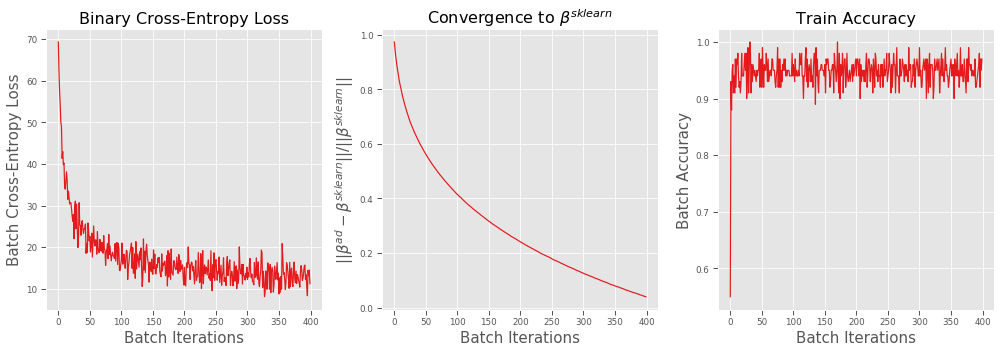

In [36]:
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.plot(f)
plt.ylabel("Batch Cross-Entropy Loss", fontsize=15)
#plt.ylim(bottom=-10, top=450)
plt.xlabel(r"Batch Iterations", fontsize=15)
plt.title("Binary Cross-Entropy Loss", fontsize=16)

plt.subplot(1,3,2)
plt.plot(error)
plt.ylabel(r"$||\beta^{ad} - \beta^{sklearn}||/||\beta^{sklearn}||$", fontsize=15)
#plt.ylim(bottom=-10, top=450)
plt.xlabel(r"Batch Iterations", fontsize=15)
plt.title(r"Convergence to $\beta^{sklearn}$", fontsize=16)

plt.subplot(1,3,3)
plt.plot(acc)
plt.ylabel(r"Batch Accuracy", fontsize=15)
#plt.ylim(bottom=-10, top=450)
plt.xlabel(r"Batch Iterations", fontsize=15)
plt.title("Train Accuracy", fontsize=16)
plt.tight_layout()
plt.savefig("logistic_regression.png", dpi=300)